# DLOps Assignment - 4 

    Ayush Abrol B20AI052

---

### Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms, utils, models
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from PIL import Image
from torch.autograd import Variable 
import timeit
import copy

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

c:\Users\Ayush Abrol\AppData\Local\Programs\Python\Python37\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


## Question 1

Train a Conditional Deep Convolutional Generative Adversarial Network (cDCGAN) on Dataset.

A. Generate 50 Samples of each class from your trained generator. 
B. Train a ResNet18 classifier on the given dataset and treat the generated samples as test
dataset and report following 

    - F1 Score for each class
    - Confusion matrix

### Reading the GAN_data.csv file

In [2]:
df = pd.read_csv('./data/GAN_data.csv')

In [3]:
df

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,...,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,digit_9
91996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,digit_9
91997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,digit_9
91998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,digit_9


### Separating the columns for pixels and labels

In [4]:
images = df.drop('character', axis=1).values
labels = df['character'].values

#### Converting pixel data from strings to floats

In [5]:
images = images.astype('float32')

In [6]:
images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
print('Initial shape of the image dataset: ', images.shape)

Initial shape of the image dataset:  (92000, 1024)


### Normalizing the images between -1 and 1

In [8]:
images = (images/127.5) - 1

### Reshaping to 32x32 from 1x1024

In [9]:
images = images.reshape(92000, 32, 32)

In [10]:
print('Updated shape of the image dataset: ', images.shape)

Updated shape of the image dataset:  (92000, 32, 32)


### Labels

In [11]:
labels

array(['character_01_ka', 'character_01_ka', 'character_01_ka', ...,
       'digit_9', 'digit_9', 'digit_9'], dtype=object)

### Classes

In [12]:
classes = np.unique(labels)
print('Unique labels: ', classes)

Unique labels:  ['character_01_ka' 'character_02_kha' 'character_03_ga' 'character_04_gha'
 'character_05_kna' 'character_06_cha' 'character_07_chha'
 'character_08_ja' 'character_09_jha' 'character_10_yna'
 'character_11_taamatar' 'character_12_thaa' 'character_13_daa'
 'character_14_dhaa' 'character_15_adna' 'character_16_tabala'
 'character_17_tha' 'character_18_da' 'character_19_dha' 'character_20_na'
 'character_21_pa' 'character_22_pha' 'character_23_ba' 'character_24_bha'
 'character_25_ma' 'character_26_yaw' 'character_27_ra' 'character_28_la'
 'character_29_waw' 'character_30_motosaw' 'character_31_petchiryakha'
 'character_32_patalosaw' 'character_33_ha' 'character_34_chhya'
 'character_35_tra' 'character_36_gya' 'digit_0' 'digit_1' 'digit_2'
 'digit_3' 'digit_4' 'digit_5' 'digit_6' 'digit_7' 'digit_8' 'digit_9']


### Encoding the labels

In [13]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
print(encoded_labels)

[ 0  0  0 ... 45 45 45]


In [14]:
print('Shape of the encoded labels: ', encoded_labels.shape)

Shape of the encoded labels:  (92000,)


### Encoded classes

In [15]:
classes_encoded = np.unique(encoded_labels)
print('Unique encoded labels: ', classes_encoded)

Unique encoded labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


### Shuffling the dataset

In [16]:
randomize = np.arange(len(images))
np.random.shuffle(randomize)
images_shuffled = images[randomize]
labels_shuffled = encoded_labels[randomize]

### Visualizing the dataset

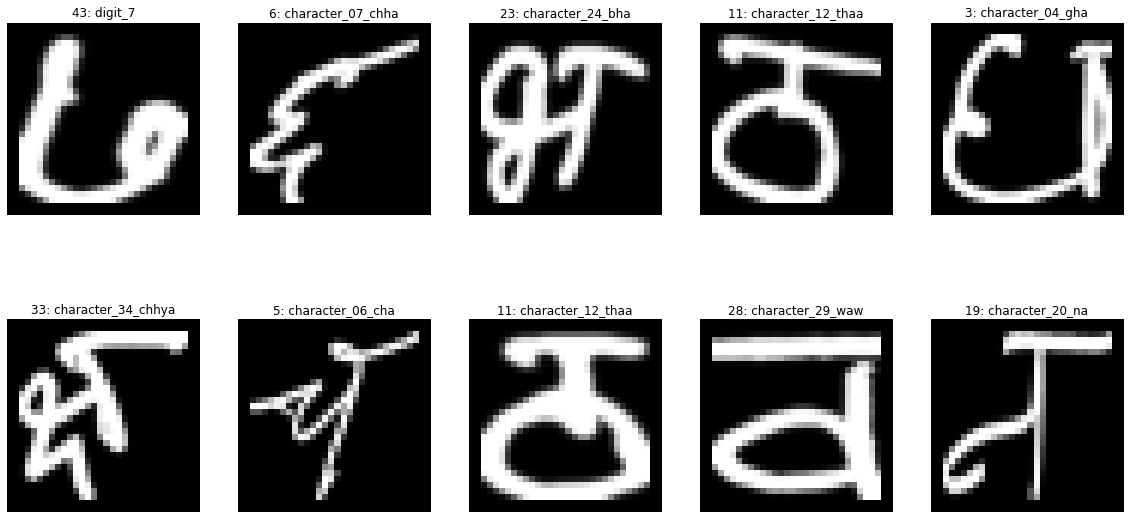

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images_shuffled[i], cmap='gray')
    ax.set_title(str(labels_shuffled[i])+': '+str(classes[labels_shuffled[i]]))
    ax.axis('off')
plt.show()

### Creating PyTorch Dataset

In [18]:
class ImageDataset(Dataset):
    def __init__(self, pixels, labels):
        self.pixels = pixels
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        pixel_data = self.pixels[idx]
        label_data = self.labels[idx]
        return torch.from_numpy(pixel_data), torch.tensor(label_data)

### Creating PyTorch DataLoader

In [19]:
image_data = ImageDataset(images_shuffled, labels_shuffled)

# Create PyTorch DataLoader
batch_size = 128
train_loader = DataLoader(image_data, batch_size=batch_size, shuffle=True)

### Shape of each batch

In [43]:
for images, labels in train_loader:
    print('Shape of the images in a single batch: ', images.shape)
    print('Shape of the labels in a single batch: ', labels.shape)
    break

Shape of the images in a single batch:  torch.Size([128, 32, 32])
Shape of the labels in a single batch:  torch.Size([128])


### Setting the device to GPU if available

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Defining the Generator class

In [21]:
class Generator(nn.Module):
    def __init__(self, latent_dim, n_classes, embedding_dim):
        super(Generator, self).__init__()
        self.n_classes = n_classes
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim
      
        self.label_conditioned_generator = nn.Sequential(nn.Embedding(self.n_classes, self.embedding_dim),
                    nn.Linear(self.embedding_dim, 256),
                    nn.LeakyReLU(0.2, inplace=True),
                    nn.Linear(256, 1*8*8),
                    nn.LeakyReLU(0.2, inplace=True))
         
     
        self.latent = nn.Sequential(nn.Linear(self.latent_dim, 8*8*256),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   )
            
 
        self.model = nn.Sequential(nn.ConvTranspose2d(257, 128, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(128, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(128, 1, 4, 2, 1,bias=False),
                      nn.Tanh())
 
    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 8, 8)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 256, 8, 8)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        return image

### Defining the Discriminator class

In [22]:
class Discriminator(nn.Module):
    def __init__(self, n_classes, embedding_dim):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.embedding_dim = embedding_dim
     
        self.label_condition_disc = nn.Sequential(nn.Embedding(self.n_classes, self.embedding_dim),
                      nn.Linear(self.embedding_dim, 1*32*32))
              
        self.model = nn.Sequential(nn.Conv2d(2, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(2048, 1),
                      nn.Sigmoid()
                     )
 
    def forward(self, inputs):
        img, label = inputs
        img = img.view(-1, 1, 32, 32)
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 1, 32, 32)
        concat = torch.cat((img, label_output), dim=1)
        output = self.model(concat)
        return output

### Instantiating the Generator and Discriminator 

In [23]:
latent_dim = 100
n_classes = 46
embedding_dim = 16
generator = Generator(latent_dim, n_classes, embedding_dim).to(device)

n_classes = 46
embedding_dim = 16
discriminator = Discriminator(n_classes, embedding_dim).to(device)

### Defining optimizer for both the models

In [24]:
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Generator Loss

In [26]:
def generator_loss(fake_output, label):
    gen_loss = nn.BCELoss()(fake_output, label)
    return gen_loss

### Discriminator Loss

In [27]:
def discriminator_loss(output, label):
    disc_loss = nn.BCELoss()(output, label)
    return disc_loss

In [29]:
num_epochs = 268
discriminator_loss_list = []
generator_loss_list = []

### Training the Generator and the Discriminator

In [ ]:
print("Training Started...")
print("-"*50)
start_time = timeit.default_timer()
total_time = 0

for epoch in range(1, num_epochs+1): 
 
    D_loss_list, G_loss_list = [], []
    
    for index, (real_images, labels) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)
        labels = labels.to(device)
        labels = labels.unsqueeze(1).long()
 
       
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))
       
        D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
     
        noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
        noise_vector = noise_vector.to(device)
         
        
        generated_image = generator((noise_vector, labels))
        output = discriminator((generated_image.detach(), labels))
        D_fake_loss = discriminator_loss(output,  fake_target)
       
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
       
        D_total_loss.backward()
        D_optimizer.step()
 
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
        G_loss_list.append(G_loss)
 
        G_loss.backward()
        G_optimizer.step()

        if index % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Batch {index+1}/{len(train_loader)} \
            Loss D: {D_total_loss:.4f}, loss G: {G_loss:.4f}')

    
    print(f'Epoch [{epoch}/{num_epochs}] Batch {index+1}/{len(train_loader)} \
            Loss D: {D_total_loss:.4f}, loss G: {G_loss:.4f}')
    discriminator_loss_list.append(torch.mean(torch.FloatTensor(D_loss_list)))
    generator_loss_list.append(torch.mean(torch.FloatTensor(G_loss_list)))

    stop = timeit.default_timer()
    total_time += stop - start_time

    print(f"Time Elapsed for Epoch {epoch}: {stop - start_time} seconds")
    print(f"Total Time Elapsed: {total_time} seconds")
    print("-"*50)

    if epoch % 5 == 0:
        # Saving the Generator and Discriminator models
        torch.save(generator.state_dict(), f'./generator_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'./discriminator_{epoch}.pth')

        # Saving fake images
        noise_vector = torch.randn(1, latent_dim, device=device)
        noise_vector = noise_vector.to(device)
        labels = torch.randint(0, 46, (1, 1), device=device)
        labels = labels.unsqueeze(1).long()
        fake_image = generator((noise_vector, labels))
        fake_image = fake_image.view(32, 32)
        fake_image = fake_image.cpu().detach().numpy()
        plt.imsave(f'./fake_image_{epoch}.png', fake_image, cmap='gray')

print("Training Finished!")
print("Total Time Elapsed: {} seconds".format(total_time))

### Loading the saved generator and discriminator model

In [31]:
generator.load_state_dict(torch.load('./models/generator_268.pth'))
discriminator.load_state_dict(torch.load('./models/discriminator_268.pth'))

<All keys matched successfully>

### Loading the saved generator and discriminator loss files

In [ ]:
discriminator_loss_list = np.load('./loss_files/discriminator_loss.npy')
generator_loss_list = np.load('./loss_files/generator_loss.npy')

### Generating 50 samples of each class

In [37]:
import os
latent_dim = 100
n_classes = 46
embedding_dim = 16

generator.eval()
discriminator.eval()

for i in range(46):
    noise_vector = torch.randn(50, latent_dim, device=device)
    noise_vector = noise_vector.to(device)
    labels = torch.ones(50, 1, device=device) * i
    labels = labels.unsqueeze(1).long()
    generated_image = generator((noise_vector, labels))
    generated_image = generated_image.view(50, 32, 32)
    generated_image = generated_image.cpu().detach().numpy()
    for j in range(50):
        if not os.path.exists(f'./trained_GAN_generated_images/{i}'):
            os.makedirs(f'./trained_GAN_generated_images/{i}')
        plt.imsave(f'./trained_GAN_generated_images/{i}/{j}.png', generated_image[j], cmap='gray')

### Training a ResNet18 classifier on the given dataset

In [65]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, 46)
resnet18 = resnet18.to(device)

In [66]:
optimizer_resnet18 = torch.optim.Adam(resnet18.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_loss_list = []
train_acc_list = []

In [67]:
def train_classifier(model, train_loader, optimizer, criterion, train_loss_list, train_acc_list, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        for index, (images, labels) in enumerate(tqdm(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            images = images.reshape(-1, 1, 32, 32)
            images = images.repeat(1, 3, 1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc)
        print(f'Epoch {epoch+1}/{num_epochs} \
        Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.4f}')
        print("="*50)

In [68]:
print("Training ResNet18 Classifier on the original dataset")
train_classifier(resnet18, train_loader, optimizer_resnet18, criterion, train_loss_list, train_acc_list, num_epochs)
print("Training Finished!")

Training ResNet18 Classifier on the original dataset


100%|██████████| 719/719 [00:36<00:00, 19.51it/s]


Epoch 1/10         Loss: 0.2755 Acc: 92.5859


100%|██████████| 719/719 [00:37<00:00, 19.38it/s]


Epoch 2/10         Loss: 0.0674 Acc: 98.0772


100%|██████████| 719/719 [00:33<00:00, 21.33it/s]


Epoch 3/10         Loss: 0.0495 Acc: 98.5533


100%|██████████| 719/719 [00:35<00:00, 20.22it/s]


Epoch 4/10         Loss: 0.0375 Acc: 98.9533


100%|██████████| 719/719 [00:37<00:00, 19.23it/s]


Epoch 5/10         Loss: 0.0349 Acc: 98.9848


100%|██████████| 719/719 [00:35<00:00, 20.05it/s]


Epoch 6/10         Loss: 0.0312 Acc: 99.1272


100%|██████████| 719/719 [00:34<00:00, 20.63it/s]


Epoch 7/10         Loss: 0.0249 Acc: 99.2989


100%|██████████| 719/719 [00:34<00:00, 21.01it/s]


Epoch 8/10         Loss: 0.0248 Acc: 99.2848


100%|██████████| 719/719 [00:36<00:00, 19.48it/s]


Epoch 9/10         Loss: 0.0238 Acc: 99.3239


100%|██████████| 719/719 [00:36<00:00, 19.90it/s]


Epoch 10/10         Loss: 0.0179 Acc: 99.4815
Training Finished!


### Saving the trained ResNet18 model

In [72]:
torch.save(resnet18.state_dict(), './models/resnet18.pth')

### Loading the saved ResNet18 model

In [ ]:
resnet18.load_state_dict(torch.load('./models/resnet18.pth'))

### Using generated samples as test dataset

In [73]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = torchvision.datasets.ImageFolder(root='./trained_GAN_generated_images', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

### Shape of a batch of generated samples which are being used as test dataset

In [74]:
for img, label in test_loader:
    print(img.shape)
    print(label.shape)
    break

torch.Size([32, 3, 32, 32])
torch.Size([32])


### Testing the Generator model on the generated samples

In [85]:
def test_classifier(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for index, (images, labels) in enumerate(tqdm(test_loader)):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    return y_pred, y_true

### Obtaining the required metrics

In [89]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
y_pred, y_true = test_classifier(resnet18, test_loader)
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"F1 Score: {f1_score(y_true, y_pred, average='macro')}")

100%|██████████| 72/72 [00:04<00:00, 17.20it/s]

Accuracy: 72.34782608695653
F1 Score: 0.6624172249160296


## Question 2

Train a CNN based classification model and perform Optimized Hyperparameter Tuning using
Optuna Library on the below-mentioned dataset. Perform 100 trials.
Hyperparameters should be

    - No of Convolution Layers 3 to 6
    - Number of Epochs 10 to 50
    - Learning rate 0.0001 to 0.1
    
Report the observations and the best trial. Report how many trials were pruned
For Even Roll Number (B20AI052) MNIST Dataset

### Importing optuna

In [2]:
import os
import optuna
from optuna.trial import TrialState

### Setting up the configuration

In [4]:
batch_size_train = 64
batch_size_test = 50
number_of_trials = 100
limit_obs = True
num_classes = 10
dir = os.getcwd()
print(dir)

c:\Users\Ayush Abrol\Desktop\Deep Learning CSL4020\DLOps Assignments\Assignment -4 GANs and Optuna


In [5]:
limit_obs = True
if limit_obs:
    number_of_train_images = 500*batch_size_train
    number_of_test_images = 100*batch_size_test
else:
    number_of_train_images = 60000
    number_of_test_images = 10000

### Loading the MNIST dataset (B20AI052 - Even Roll Number)

In [6]:
def get_data_mnist():
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', train=True, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                           (0.1307,), (0.3081,)),
                                        torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1))
                                   ])), batch_size=batch_size_train, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', train=False, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                           (0.1307,), (0.3081,)),
                                        torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1))
                                   ])), batch_size=batch_size_test, shuffle=False)

    return train_loader, test_loader

### Defining the CNN architecture with number of convolution layers and number of fc_layers as hyperparameters

In [7]:
class CNN(nn.Module):
    def __init__(self, trial, num_conv_layers, num_fc_layers):
        super(CNN, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.num_fc_layers = num_fc_layers
        
        self.conv_layers = nn.ModuleList()
        in_channels = 3 
        for i in range(num_conv_layers):
            out_channels = 64 
            kernel_size = 3 
            stride = 1 
            padding = 1 
            conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            in_channels = out_channels
            self.conv_layers.append(conv_layer)
        
        self.fc_layers = nn.ModuleList()
        in_features = 64 * 28 * 28 
        for i in range(num_fc_layers):
            out_features = 512 
            fc_layer = nn.Linear(in_features, out_features)
            in_features = out_features
            self.fc_layers.append(fc_layer)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
            x = self.relu(x)
        x = x.view(x.size(0), -1)
        for fc_layer in self.fc_layers:
            x = fc_layer(x)
            x = self.relu(x)
        return x

### Defining the get_cnn function

In [8]:
def get_cnn(trial):
    num_conv_layers = trial.suggest_int("num_conv_layers", 3, 6)
    num_fc_layers = trial.suggest_int("num_fc_layers", 1, 3)
    return CNN(trial, num_conv_layers, num_fc_layers)

### Defining the objective function to be optimized using optuna

In [9]:
def objective(trial):
    model = get_cnn(trial).to(device)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader, test_loader = get_data_mnist()
    epochs = trial.suggest_int("epochs", 10, 50)
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            if batch_idx * batch_size_train > number_of_train_images:
                break
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
        print
        
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                if batch_idx * batch_size_test > number_of_test_images:
                    break
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        accuracy = correct / number_of_test_images
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return accuracy

### Defining the study and optimizing the objective function (accuracy)

In [11]:
opt_study = optuna.create_study(direction="maximize")
opt_study.optimize(objective, n_trials=number_of_trials)
pruned_trials = opt_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = opt_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

[I 2023-04-27 13:28:41,806] A new study created in memory with name: no-name-979a8646-bfac-4b05-975c-9d105e1ec094
[I 2023-04-27 13:41:48,708] Trial 0 finished with value: 0.7788 and parameters: {'num_conv_layers': 6, 'num_fc_layers': 2, 'lr': 0.00041191393701745557, 'epochs': 35}. Best is trial 0 with value: 0.7788.
[I 2023-04-27 13:57:25,351] Trial 1 finished with value: 0.9966 and parameters: {'num_conv_layers': 5, 'num_fc_layers': 2, 'lr': 0.0001679140980483938, 'epochs': 47}. Best is trial 1 with value: 0.9966.
[I 2023-04-27 14:08:47,555] Trial 2 finished with value: 0.6998 and parameters: {'num_conv_layers': 6, 'num_fc_layers': 3, 'lr': 0.0001675329511465571, 'epochs': 31}. Best is trial 1 with value: 0.9966.
[I 2023-04-27 14:17:48,108] Trial 3 finished with value: 0.7772 and parameters: {'num_conv_layers': 3, 'num_fc_layers': 1, 'lr': 0.0020854909041265533, 'epochs': 35}. Best is trial 1 with value: 0.9966.
[I 2023-04-27 14:28:41,388] Trial 4 finished with value: 0.1154 and param

### Plotting the optimization history of all trials in a study.

In [13]:
fig = optuna.visualization.plot_optimization_history(opt_study) 
fig.show()

In [14]:
fig = optuna.visualization.plot_slice(opt_study) 
fig.show()

### Parallel Coordinate Plot

In [15]:
fig = optuna.visualization.plot_parallel_coordinate(opt_study)
fig.show()

### Study Statistics

In [16]:
print("\nStudy statistics: ")
print("  Number of finished trials: ", len(opt_study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))


Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  72
  Number of complete trials:  28


### Best Trial

In [17]:
print("\nBest trial:")
trial = opt_study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Best trial:
  Value:  0.9992
  Params: 
    num_conv_layers: 6
    num_fc_layers: 2
    lr: 0.0005119114367877431
    epochs: 41


### Saving the best trial

In [18]:
import pickle
with open("optuna_study.pkl", "wb") as f:
    pickle.dump(opt_study, f)